<a href="https://colab.research.google.com/github/MatheusOrange211/Sirio_Libanes_ICU_Prediction/blob/main/Visualizando_os_dados_Sirio_Libanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploração dos dados - Buscando entender um pouco mais o que temos

Para entendermos melhor como nosso conjunto de dados é e qual modelo ir implementando, primeiro devemos entender o que temos de dados. Afinal, saber quais dados são faltantes, quais informações podemos ter que realmente ajudarão, dentre outras coisas, serão de caráter fundamental para o modelo obter uma boa performance. Abaixo, lhe mostro o que possuímos e como o modelo que apliquei auxiliará no dia-a-dia do hospital, no que tange a tomada de decisões.

Primeiramente importo as bibliotecas que serão usadas nesta parte do projeto. Elas contêm ferramentas necessárias para a exploração dos dados.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno

sns.set()

#DADOS

In [13]:
dados = pd.read_excel("https://github.com/MatheusOrange211/Sirio_Libanes_ICU_Prediction/raw/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

#FUNÇÕES 

Essa função retorna um resumo simples do que temos no nosso conjunto de dados. Informações como quantidade de linhas e colunas e quantidade totais de valores Not a Number (Nan), que causam muitos problemas na hora de maninpular dados, são apresentados.

In [15]:
def resume_dataframe(dataset  : pd.DataFrame):
  
  data_nan = dataset.isnull().any().any()
  dataset_types = list (set(dataset.dtypes.values))
  print("################ RESUMO BÁSICO ####################\n")
  print(f"Quantidade de instâncias: {len(dados)} (linhas)\nQuantidade de Atributos: {len(dados.columns)} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")
  print("##################################################\n")

Essa função é responsável por gerar uma tabela detalhada e formatada sobre determinada coluna. As informações que ela gera ajudam a compreeender mais sobre o comportamento de terminada coluna e sua distribuição a longo da tabela.


In [78]:
def formated_table(dataset : pd.DataFrame, dicionario : dict  = None, title_index :str = None):
  frequency = dataset.value_counts()
  percentage = (dataset.value_counts(normalize=True) * 100).round(3)
  final_dataset = pd.DataFrame({"Frequencia":frequency,"Porcentagem":percentage})

  if dicionario:
    final_dataset.rename(index = dicionario, inplace = True)
  
  if title_index:
    final_dataset.rename_axis(title_index,axis=1,inplace=True)
  
  return final_dataset

A função abaixo será responsável por cruzar duas colunas de dados. Dela podemos averiguar questões como:
Quantos porcento das pessoas que forma admitidas em um intervalo de até 2 horas necessitaram de UTI? ou até mesmo, das pessoas que foram internadas, quantos porcento foram admitidas num intervalo de mais de 12 horas.

In [79]:
def crosstab_data(dataset1: pd.DataFrame, dataset2:pd.DataFrame,normal:str = "index",dicio1:dict= None, dicio2: dict = None):
    dataframe = (pd.crosstab(dataset1,dataset2,normalize=f"{normal}")*100).round(2)
    
    if dicio1:
      dataframe.rename(index=dicio1,inplace=True)

    if dicio2:
      dataframe = dataframe.rename(columns=dicio2)
    
    return dataframe

#PARTINDO PARA A ANÁLISE

Pra começar, vamos ver o que temos logo de cara no dataset. Compreender sua composição é de fundamental importância para uma boa tomada de decisão.

In [12]:
dados.head(3)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0


Acima, imprimimos apenas as 3 primeiras linhas do DataFrame. A quantidade de colunas é grande e podemos analisar isso ou pouco melhor abaixo

In [16]:
resume_dataframe(dados)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 1925 (linhas)
Quantidade de Atributos: 231 (colunas)

Possui dados NaN ? True
Quantidade de NaN totais: 223863

Tipos de  dados que temos :
[dtype('int64'), dtype('O'), dtype('float64')]

##################################################



Temos **1925** linhas e **231** colunas no total. Nosso dataframe `dados` (nome que darei para o conjunto de dados original), possui valores NaN em um total de **22363** células. Isso significa que precisaremos tratar estes dados e buscar tratar estes valores ausentes para quando treinado, não termos problemas de desemepenho no modelo. Contudo, neste Notebook, nos antentaremos apenas em explorar os dados. Por fim, temos uma lista de informções que nos indicam que temos  dados do tipo **Inteiro** (*int64*), tipo **Object** (*o*) e tipo **Real** ou **Float**, em inglês (*float64*).
Para fins de conhecimento temos que para tipo **Object**:
>O Object tipo de dados pode apontar para dados de qualquer tipo de dados, incluindo qualquer instância de objeto que seu aplicativo reconhece. ([Link para Leitura](https://docs.microsoft.com/pt-br/dotnet/visual-basic/language-reference/data-types/object-data-type#:~:text=O%20Object%20tipo%20de%20dados,objeto%20que%20seu%20aplicativo%20reconhece.))

##Compreendendo um pouco mais sobre Not a Number - NaN

**Not a Number** ou apenas **NaN** é definido como:
>  Um valor ou símbolo usado nas linguagens de programação para representar um valor numérico indefinido ou irrepresentável. Seu uso sistemático foi introduzido pelo padrão IEEE 754 em 1985, junto com a representação de outras quantidade não finitas tais como infinitos ([link para leitura](https://pt.wikipedia.org/wiki/NaN))

Na análise de dados, NaN devem ser tratados com muita atenção. Dados Ausentes, conforme lista Matt Harrison, autor de *Machine Learning - Guia de Referência Rápida*, podem ser lidados da seguinte forma:
* Removendo qualquer linha que contenha dados ausentes;
* Removendo qualquer coluna que contenha dados ausentes;
* Imputar dados aos valores ausentes;
* Criar uma coluna  para informar que os dados estavam ausentes.

Contudo, em cada caso, devemos avaliar bem a forma como iremos tratar esse tipo de dados. Apenas descartar, por exemplo, todas as linhas com dados ausentes, pode reduzir drasticamente nosso dataframe, e isso pode impactar negativamente o desempenho do nosso modelo.<br>
Vamos então explorar estes dados NaN, e ver qual a sua porcentagem em relação as colunas.

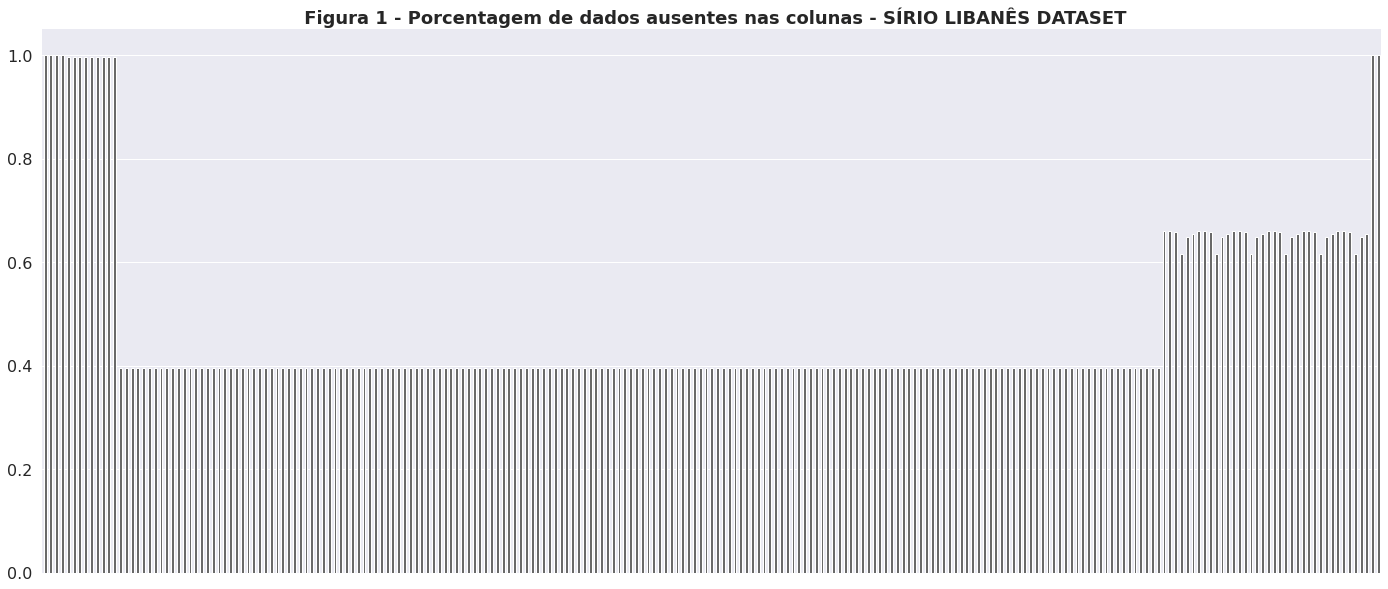

In [94]:
grafico_dados_faltantes = msno.bar(dados.sample(500))
plt.title(" Figura 1 - Porcentagem de dados ausentes nas colunas - SÍRIO LIBANÊS DATASET",
          size=18,weight='bold')

grafico_dados_faltantes.get_figure();

Com a ajuda da biblioteca Missingno, podemos analisar nosso conjunto de dados de forma global e ver como todas as colunas se comportam em relação a quantidade de dados ausentes. Abaixo temos uma visão geral que mostra que grande parte das colunas apresentam apenas 40% de dados, sendo o resto em sua maioria, valores NaN.

Tendo essas informações já temos uma boa noção de que simplesmente descartar linhas e/ou colunas com dados faltantes não será uma boa ideia. O ideal será imputar valores neste caso. Isso abordamos em outro momento. Continuemos explorando nossos dados.

Uma coisa muito importante para o andamento do projeto é entender sobre as chamadas "janelas" ou "windows" que o dataset possui. Essa coluna possui informações referentes ao tempo que o paciente deu entrada no hospital. Quanto mais cedo nosso modelo conseguir prever, melhor será para os profissionais de saúde e equipe médica em relação ao tratamento, quanto para o paciente, o principal beneficiado por um atendimento e tratamento rápido que pode lhe custar a vida se negado. Vejamos um pouco sobre essa coluna e o que temos dela no geral

In [74]:
intervalo_admissao = {"0-2": "Até 2h","2-4":"De 2h até 4h","4-6": "De 4h até 6h",	
                      "6-12": "De 6h até 12h","ABOVE_12":"Acima de 12h"}
                      
formated_table(dados['WINDOW'],dicionario=intervalo_admissao)

,Frequencia,Porcentagem
De 2h até 4h,385,20.0
Até 2h,385,20.0
De 6h até 12h,385,20.0
Acima de 12h,385,20.0
De 4h até 6h,385,20.0


A distribuição dos dados para a coluna `WINDOW` apresenta-se precisamente dividida. Possuímos os cenários bem definidos e a partir deles, podemos buscar treinar nossos modelos em cenários variados.

Contudo, outro ponto importante é entender como ficou a necessidade internação na UTI por horário de Admissão. A pergunta é:
**Dos Pacientes que foram admitidos em um intervalo X, quantos porcento precisaram de UTI?**

Primeiros, vejamos a coluna `UCI`. O que temos nela são os dados de pacientes que vão para UTI. os valores usados são 0 e 1.

In [123]:
pacientes_uti_freq_porcentagem = formated_table(dados['ICU'])
pacientes_uti_freq_porcentagem

,Frequencia,Porcentagem
0,1410,73.247
1,515,26.753


Temos uma quantidade maior de valores iguais a zero. Partiremos do pontos então que os valores iguais a zero são os pacientes que não precisam ser internados, e iguais a 1, como os pacientes que foram internados. Resumidamente, mais de **73%** dos pacientes não precisaram de UTI, enquanto cerca de **26.75 %** precisaram.

Voltando então para a análise das janelas de admissão de paciente.

In [130]:
titulo_colunas = {0:"nao_precisa_de_uti",1:"precisa_de_uti"}


janela_por_uti = crosstab_data(dados['WINDOW'],dados['ICU'],
                               normal='index',
                               dicio1=intervalo_admissao,
                               dicio2= titulo_colunas)
janela_por_uti

ICU,nao_precisa_de_uti,precisa_de_uti
WINDOW,,
Até 2h,91.69,8.31
De 2h até 4h,84.68,15.32
De 4h até 6h,74.29,25.71
De 6h até 12h,66.23,33.77
Acima de 12h,49.35,50.65


Acima temos que: **Dos pacientes admitidos em uma janela de até 2 horas, 91.69% não precisou ser internada em UTI's**. Contudo, se formos analisando com o passar das horas, vai ficando claro que esse quadro vai mudando. **Quanto mais tarde os pacientes foram admitidos, mais foi crescendo a necessidade de ser internado na UTI**, até que chegamos ao quadro de pacientes que foram admitidos em uma janela **acima de 12 horas**. Nela, **mais de 50%** dos pacientes precisaram ir para UTI. Podemos representar esse comportamento em um gráfico para ficar mais claro.

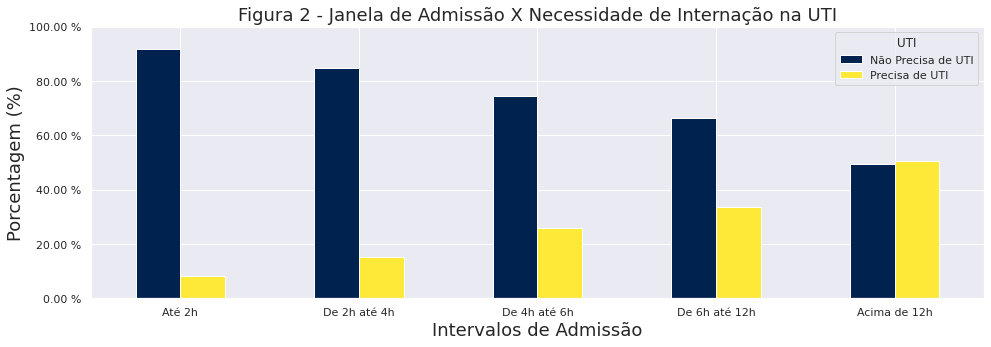

In [119]:
fig = janela_por_uti.plot(kind='bar', figsize=(16,5),colormap ='cividis')
fig.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f} %"))
plt.title("Figura 2 - Janela de Admissão X Necessidade de Internação na UTI",size=18)
fig.set_ylabel("Porcentagem (%)",size=18)
fig.set_xlabel("Intervalos de Admissão",size=18)
plt.xticks(rotation=0)
plt.ylim(0,100)

plt.legend(title='UTI',labels=['Não Precisa de UTI','Precisa de UTI'])

fig;


Acima, temos de forma mais destacada o comportamento apresentado por pacientes com janela de admissões mais tardias. A necessidade de internação em UTI vai aumentando.

Agora vejamos a distribuição das pessoas internadas ou não em relação ao tempo de admissão existente.

In [132]:
uti_por_janelas = crosstab_data(dados['WINDOW'],dados['ICU'],
                               normal='columns',
                               dicio1=intervalo_admissao,
                               dicio2= titulo_colunas)
uti_por_janelas

ICU,nao_precisa_de_uti,precisa_de_uti
WINDOW,,
Até 2h,25.04,6.21
De 2h até 4h,23.12,11.46
De 4h até 6h,20.28,19.22
De 6h até 12h,18.09,25.24
Acima de 12h,13.48,37.86


temos que mais 37 % das pessoas que estão na UTI são do grupo de admissão acima de 12 horas.